In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import pickle
def load():
    with open("mnist/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
training_images,training_y,test_images,test_y=load()

In [3]:
print(training_images.shape)
print(training_images.shape)
n_train = training_images.shape[0]
n_test = test_images.shape[0]

(60000, 784)
(60000, 784)


In [4]:
def one_hot(labels):
    """
    Encodes the labels as one-hot vectors. Zero is represented as 10 in SVHN.
    [10] -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    """
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

In [5]:
training_labels_one_hot = one_hot(training_y)
test_labels_one_hot = one_hot(test_y)

In [6]:
print(training_labels_one_hot.shape)
print(test_labels_one_hot.shape)

(60000, 10)
(10000, 10)


In [7]:
class MNIST_MLP:
    def __init__(self,wd_factor,learning_rate):
        self.wd_factor=wd_factor
        self.learning_rate=learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session()
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input')
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        print(self.input)
        
        self._build_graph()
    def _build_graph(self):
        # Note to self, every graph needs to have a loss function.
        weight=[]
        
        with tf.variable_scope("layers"):
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1')
            print(h)
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='2')
            print(h)
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='3')
            print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='4')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                      labels=self.ground_truth))
                self.loss += self.weight_decay()
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch
    
    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [8]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = MNIST_MLP(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [9]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

In [10]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(training_images, training_labels_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
training_time=end_time-start_time
print("Training time: {}s".format(training_time))

Start Training
Minibatch loss at step 0: 2.5893704891204834
Minibatch loss at step 50: 0.4599913954734802
Minibatch loss at step 100: 0.4006670415401459
Minibatch loss at step 150: 0.3112812638282776
Minibatch loss at step 200: 0.3728976845741272
Minibatch loss at step 250: 0.4275567829608917
Minibatch loss at step 300: 0.4380576014518738
Minibatch loss at step 350: 0.49965518712997437
Minibatch loss at step 400: 0.5393694043159485
Minibatch loss at step 450: 0.4253903329372406
Minibatch loss at step 500: 0.29003408551216125
Minibatch loss at step 550: 0.2760825455188751
Minibatch loss at step 600: 0.28606799244880676
Minibatch loss at step 650: 0.3441838324069977
Minibatch loss at step 700: 0.30607178807258606
Minibatch loss at step 750: 0.4323057532310486
Minibatch loss at step 800: 0.5385947823524475
Minibatch loss at step 850: 0.19423958659172058
Minibatch loss at step 900: 0.3109782934188843
Minibatch loss at step 950: 0.3662281334400177
Minibatch loss at step 1000: 0.397522300481

Minibatch loss at step 8450: 0.45135733485221863
Minibatch loss at step 8500: 0.19930365681648254
Minibatch loss at step 8550: 0.26859286427497864
Minibatch loss at step 8600: 0.23168587684631348
Minibatch loss at step 8650: 0.34328708052635193
Minibatch loss at step 8700: 0.21304593980312347
Minibatch loss at step 8750: 0.23076696693897247
Minibatch loss at step 8800: 0.2164384126663208
Minibatch loss at step 8850: 0.3420189917087555
Minibatch loss at step 8900: 0.16618993878364563
Minibatch loss at step 8950: 0.21275189518928528
Minibatch loss at step 9000: 0.21264201402664185
Minibatch loss at step 9050: 0.2818527817726135
Minibatch loss at step 9100: 0.309236079454422
Minibatch loss at step 9150: 0.24053265154361725
Minibatch loss at step 9200: 0.30570346117019653
Minibatch loss at step 9250: 0.20378762483596802
Minibatch loss at step 9300: 0.3028949797153473
Minibatch loss at step 9350: 0.29241204261779785
Minibatch loss at step 9400: 0.20058000087738037
Minibatch loss at step 945

In [11]:
training_losses = np.array(losses)
print(training_losses.shape)

(200, 2)


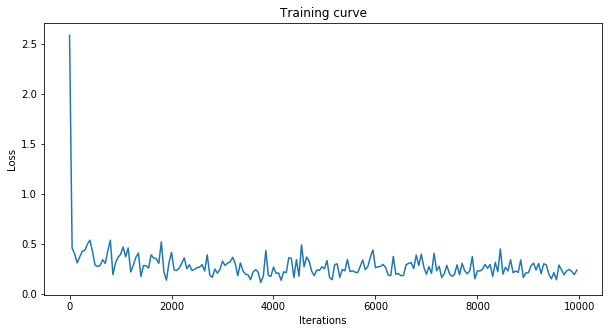

In [13]:
import matplotlib.pyplot as plt

iterations = training_losses[:, 0]
train_loss = training_losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [14]:
TEST_BATCH_SIZE = 128

model.test(test_images, test_labels_one_hot, TEST_BATCH_SIZE)

Average test loss: 0.24097123742103577


Test sample digit: 9


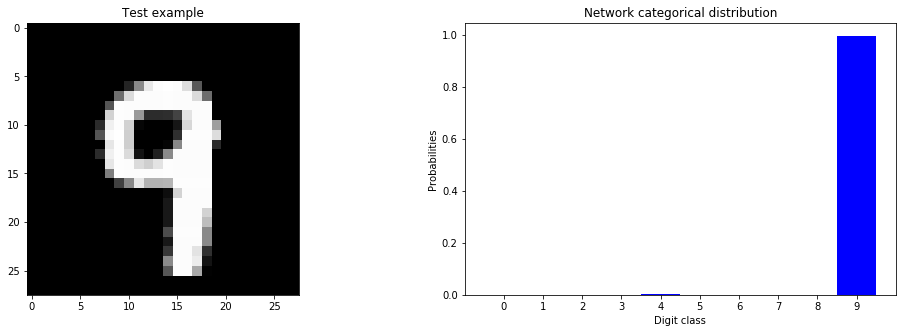

Network prediction probabilities:
[2.1048593e-06 5.2367591e-06 2.5063709e-06 6.4394379e-04 3.3522721e-03
 2.0635316e-04 2.7809654e-07 6.2105583e-04 5.8331835e-04 9.9458295e-01]


In [15]:
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_images[example], axis=0)
label = np.expand_dims(test_labels_one_hot[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [16]:
#Calculating average loss for last 100 minibatches 
total_training_loss=0
i=0
for loss in training_losses:
    i+=1
    if i>100:
        total_training_loss+=loss[1]
print(total_training_loss/100)


0.2543278409540653


In [17]:
TEST_BATCH_SIZE = 128

model.test(test_images, test_labels_one_hot, TEST_BATCH_SIZE)

Average test loss: 0.24097123742103577


In [18]:
print("The model took {} seconds to train".format(training_time))

The model took 35.906583070755005 seconds to train


The variables can mean a lot of things, so I assumed that you meant internal weights, as these are the variables we are tuning. In that case the number 6.5 X 10¹⁰ was calculated by taking 784 X 512 x 256 X 64 X 10. This is obviosly wrong as the correct answer is 784 X 512 +512x256 +256x64 + 64x10 = 549504.

# Conclusion

This model quickly converged to a good solution, I would argue already after one batch training. It has generalized, as can be seen from the similarity between the training_loss average and the test_batch average loss. As I have a fast computer, and this model was relatively small, training did not take longer than 36 seconds, which obviously is really good. 

The assignment asks for the number of variables, which can mean a lot of things, so I assumed that this signified  internal weights as these are the variables we are tuning. In that case the number 6.5 X 10¹⁰ was calculated by taking 784 X 512 x 256 X 64 X 10 at first. This is obviosly completely wrong as the correct answer is 784 X 512 +512x256 +256x64 + 64x10 = 549504.
Hope you have a lovely week. 